In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

load_dotenv()
file_path = os.getenv("FILE_PATH")
NASDAQ_prices_file = './NASDAQ Composite Index.csv'

### S&P500 Prices

In [2]:
# Load the CSV file into df
NASDAQ = pd.read_csv(NASDAQ_prices_file)
NASDAQ.columns = ["date", "price"]
NASDAQ["date"] = pd.to_datetime(NASDAQ["date"])
NASDAQ = NASDAQ.set_index("date")
NASDAQ = NASDAQ.sort_index(ascending=True)

# Calculating log prices
NASDAQ["log_returns"] = np.log(NASDAQ["price"]/ NASDAQ["price"].shift(1))
NASDAQ = NASDAQ[1:]
NASDAQ.head()

,price,log_returns
date,,
2015-01-05,4652.57,-0.015831
2015-01-06,4592.74,-0.012943
2015-01-07,4650.47,0.012491
2015-01-08,4736.19,0.018265
2015-01-09,4704.07,-0.006805


In [3]:
# Define start and end dates
NASDAQ_training_start, NASDAQ_training_end = "2015-01-02", "2022-12-31"
NASDAQ_testing_start, NASDAQ_testing_end = "2023-01-03", "2023-02-01"

# Filter the DataFrame
NASDAQ_training_df = NASDAQ[(NASDAQ.index >= NASDAQ_training_start) & (NASDAQ.index <= NASDAQ_training_end)]
NASDAQ_testing_df = NASDAQ[(NASDAQ.index >= NASDAQ_testing_start) & (NASDAQ.index <= NASDAQ_testing_end)]
NASDAQ_training_df.head()

,price,log_returns
date,,
2015-01-05,4652.57,-0.015831
2015-01-06,4592.74,-0.012943
2015-01-07,4650.47,0.012491
2015-01-08,4736.19,0.018265
2015-01-09,4704.07,-0.006805


In [5]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    """
    Performs ADF and KPSS tests on a time series.

    Parameters:
        series (pd.Series): The time series data.

    Returns:
        None (Prints test results)
    """
    # Augmented Dickey-Fuller Test (ADF)
    adf_result = adfuller(series, autolag='AIC')
    print("Augmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Stationary" if adf_result[1] < 0.05 else "➡ Non-Stationary")

    print("\n" + "="*50 + "\n")

    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags="auto")  # 'c' = constant (level stationarity)
    print("KPSS Test Results:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Non-Stationary" if kpss_result[1] < 0.05 else "➡ Stationary")

# Run the tests on S&P 500 log returns
stationarity_tests(NASDAQ["log_returns"])

Augmented Dickey-Fuller Test Results:
ADF Statistic: -16.0842
p-value: 0.0000
Critical Values:
   1%: -3.4330
   5%: -2.8627
   10%: -2.5674
➡ Stationary


KPSS Test Results:
KPSS Statistic: 0.0470
p-value: 0.1000
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
➡ Stationary


c:\Users\joshu\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [6]:
from hurst import compute_Hc

NASDAQ_hurst_est, c, data = compute_Hc(NASDAQ_training_df["log_returns"], kind='change', simplified=True)
print(f"Estimated Hurst Exponent: {NASDAQ_hurst_est:.4f}")

Estimated Hurst Exponent: 0.5874


In [7]:
from stochastic.processes.continuous import FractionalBrownianMotion
import numpy as np
import random
import plotly.graph_objects as go

def simulate_fbm_prices(train_data, test_data, H):
    """Simulate future stock prices using a geometric fractional Brownian motion model."""    
    # Calculate drift (μ) and volatility (σ) from training log returns
    mu = train_data["log_returns"].mean()
    sigma = train_data["log_returns"].std()

    # Define Fractional Brownian Motion (fBM) model
    n_days = len(test_data)
    fbm = FractionalBrownianMotion(hurst=H, t=n_days - 1)
    fbm_values = fbm.sample(n=n_days - 1)
    
    # Use the last known price from training data as the starting point
    S0 = train_data['price'].iloc[-1]
    simulated_prices = S0 * np.exp(mu * np.arange(n_days) + sigma * fbm_values)
    
    return simulated_prices

def plot_actual_vs_simulated(test_data, simulated_prices, H):
    """Create an interactive Plotly plot comparing the actual prices with simulated prices."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["price"],
        mode='lines',
        name='Actual Price',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=simulated_prices,
        mode='lines',
        name='Forecasted Price (fBM)',
        line=dict(color='red', dash='dash')
    ))
    fig.update_layout(
        title=f"Stock Price Forecast using fBM (H={H})",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )
    fig.show()

simulated_prices = simulate_fbm_prices(NASDAQ_training_df, NASDAQ_testing_df, NASDAQ_hurst_est)
plot_actual_vs_simulated(NASDAQ_testing_df, simulated_prices, NASDAQ_hurst_est)

In [8]:
def montecarlo_simulation_and_plot(train_data, test_data, H, num_simulations=100):
    """Perform a Monte Carlo simulation by generating multiple fBM price paths and plot them 
    alongside the actual stock prices."""
    
    # Calculate drift (μ) and volatility (σ) from training log returns
    mu = train_data["log_returns"].mean()
    sigma = train_data["log_returns"].std()
    
    n_days = len(test_data)
    time_points = np.arange(n_days)
    S0 = train_data['price'].iloc[-1]
    
    simulation_paths = []
    
    for i in range(num_simulations):
        # For each simulation, sample a new fBM path
        fbm = FractionalBrownianMotion(hurst=H, t=n_days - 1)
        fbm_values = fbm.sample(n=n_days - 2)
        fbm_values = np.insert(fbm_values, 0, 0)  # align with the time vector
        sim_prices = S0 * np.exp(mu * time_points + sigma * fbm_values)
        simulation_paths.append(sim_prices)
    
    # Create a Plotly figure for the Monte Carlo simulation
    fig = go.Figure()
    
    # Add each simulated path (using low opacity to avoid clutter)
    for i, sim_prices in enumerate(simulation_paths):
        fig.add_trace(go.Scatter(
            x=test_data.index,
            y=sim_prices,
            mode='lines',
            name=f'Simulation {i+1}',
            line=dict(color='rgba(255, 0, 0, 0.1)'),  # Red with transparency
            showlegend=False  # Hide individual simulation legends
        ))
    
    # Overlay the actual prices
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["price"],
        mode='lines',
        name='Actual Price',
        line=dict(color='blue', width=2)
    ))
    
    # Update plot layout
    fig.update_layout(
        title=f"Monte Carlo Simulation of Stock Prices using fBM (H={H}) - {num_simulations} Paths",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )
    
    fig.show()

montecarlo_simulation_and_plot(NASDAQ_training_df, NASDAQ_testing_df, NASDAQ_hurst_est, num_simulations=100)

In [9]:
def compute_rolling_hurst(df, window, col='log_returns', lag=0):
    hurst_values = []
    times = []
    
    # Loop through the DataFrame using the rolling window
    for i in range(window - 1, len(df), lag+1):

        # Extract the window slice from the series
        window_series = df[col].iloc[i - window + 1 : i + 1: lag+1]
        
        # Compute the Hurst exponent using the 'change' method and simplified calculation
        h, c, data = compute_Hc(window_series, kind='change', simplified=True)
        
        hurst_values.append(h)
        times.append(df.index[i])
    
    # Create and return a new DataFrame with the computed Hurst exponents
    result_df = pd.DataFrame({'hurst': hurst_values}, index=times)
    return result_df

hurst_window150_lag0 = compute_rolling_hurst(NASDAQ, window=150, col='log_returns', lag=0)
hurst_window350_lag0 = compute_rolling_hurst(NASDAQ, window=350, col='log_returns', lag=0)
hurst_window500_lag0 = compute_rolling_hurst(NASDAQ, window=500, col='log_returns', lag=0)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=hurst_window150_lag0.index,
    y=hurst_window150_lag0["hurst"],
    mode='lines',
    name='150 days rolling window',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=hurst_window350_lag0.index,
    y=hurst_window350_lag0["hurst"],
    mode='lines',
    name='350 days rolling window',
    line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=hurst_window500_lag0.index,
    y=hurst_window500_lag0["hurst"],
    mode='lines',
    name='500 days rolling window',
    line=dict(color='green')
))
fig.update_layout(
    title=f"Hurst exponent for NASDAQ",
    xaxis_title="Date",
    yaxis_title="Hurst Value",
    template="plotly_white"
)

In [10]:
def compute_hit_ratio(df, hurst_col='hurst', return_col='log_returns', threshold=0.5):
    """Compute the hit ratio for a trading strategy based on the Hurst exponent."""
    df = df.dropna().copy()  # Ensure no NaNs

    # Generate trading signals based on Hurst exponent
    df['signal'] = np.where(df[hurst_col] > threshold, 1, -1)  # 1 for trending, -1 for mean-reverting

    # Shift returns forward to compare with the signal
    df['future_return'] = df[return_col].shift(-1)  # Next-period return

    # Correct predictions: signal * future return > 0 means correct prediction
    df['correct'] = np.sign(df['signal'] * df['future_return']) == 1

    # Compute hit ratio
    hit_ratio = df['correct'].mean()
    return hit_ratio

hit_150_0_df = NASDAQ.join(hurst_window150_lag0, how='inner')
hit_350_0_df = NASDAQ.join(hurst_window350_lag0, how='inner')
hit_500_0_df = NASDAQ.join(hurst_window500_lag0, how='inner')

hit_150_0 = compute_hit_ratio(hit_150_0_df)
hit_350_0 = compute_hit_ratio(hit_350_0_df)
hit_500_0 = compute_hit_ratio(hit_500_0_df)

print(f"Hit Ratios:\n"
      f"- 150-day window (0 lag): {hit_150_0:.2%}\n"
      f"- 350-day window (0 lag): {hit_350_0:.2%}\n"
      f"- 500-day window (0 lag): {hit_500_0:.2%}")

Hit Ratios:
- 150-day window (0 lag): 51.78%
- 350-day window (0 lag): 51.43%
- 500-day window (0 lag): 50.45%


In [11]:
# Using different lags
hurst_window150_lag2 = compute_rolling_hurst(NASDAQ, window=150, col='log_returns', lag=0)
hurst_window350_lag2 = compute_rolling_hurst(NASDAQ, window=350, col='log_returns', lag=2)
hurst_window500_lag2 = compute_rolling_hurst(NASDAQ, window=500, col='log_returns', lag=4)

hit_150_2_df = NASDAQ.join(hurst_window150_lag2, how='inner')
hit_350_2_df = NASDAQ.join(hurst_window350_lag2, how='inner')
hit_500_2_df = NASDAQ.join(hurst_window500_lag2, how='inner')

hit_150_2 = compute_hit_ratio(hit_150_2_df)
hit_350_2 = compute_hit_ratio(hit_350_2_df)
hit_500_2 = compute_hit_ratio(hit_500_2_df)

print(f"Hit Ratios:\n"
      f"- 150-day window: {hit_150_2:.2%}\n"
      f"- 350-day window: {hit_350_2:.2%}\n"
      f"- 500-day window: {hit_500_2:.2%}")

Hit Ratios:
- 150-day window: 51.78%
- 350-day window: 47.23%
- 500-day window: 47.03%


### Run fBM Model on data post-2022

In [12]:
import utils

nasdaq_obj = utils.SnpDf(NASDAQ)
result_df = utils.apply_rolling_predictions_from_start(nasdaq_obj, '2022-01-01', 150)
result_df.head()

,predicted
2021-05-28,13531.691353
2021-06-01,13726.094758
2021-06-02,13831.817120
2021-06-03,13711.511329
2021-06-04,13397.333680


In [13]:
merged_df = result_df.join(NASDAQ, how='inner')
merged_df.head()

,predicted,price,log_returns
2021-05-28,13531.691353,13748.74,0.000907
2021-06-01,13726.094758,13736.48,-0.000892
2021-06-02,13831.817120,13756.33,0.001444
2021-06-03,13711.511329,13614.51,-0.010363
2021-06-04,13397.333680,13814.49,0.014582


In [14]:
utils.compute_rmse(merged_df, 'predicted', 'price')

268.2504428337366

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["predicted"],
    mode='lines',
    name='Predicted',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["price"],
    mode='lines',
    name='Actual',
    line=dict(color='red')
))
fig.update_layout(
    title=f"Predicted vs Actual Price",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_white"
)

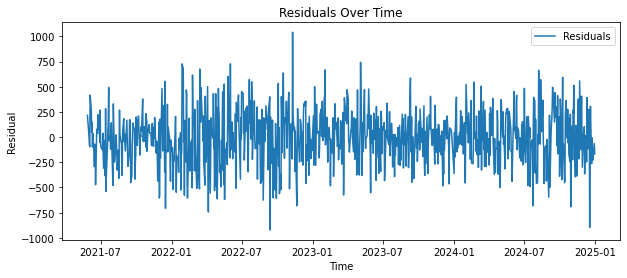

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# 1. Compute the residuals
df = merged_df 
df['residual'] = df['price'] - df['predicted']

# 2. Plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['residual'], label='Residuals')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.show()

Observations:
- Large spikes, indicating many outliers 
- Residuals oscillate around zero (good)
- No obvious trend

c:\Users\joshu\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



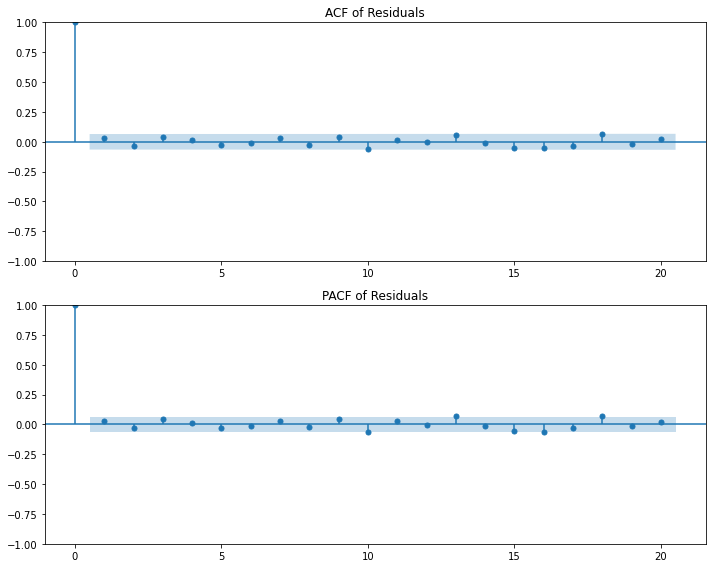

In [17]:
# 3. Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['residual'], lags=20, ax=ax[0])
plot_pacf(df['residual'], lags=20, ax=ax[1])
ax[0].set_title("ACF of Residuals")
ax[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

Observations:
- No signification autocorrelation (since no spikes), captured temporal dependencies well
- Good fit

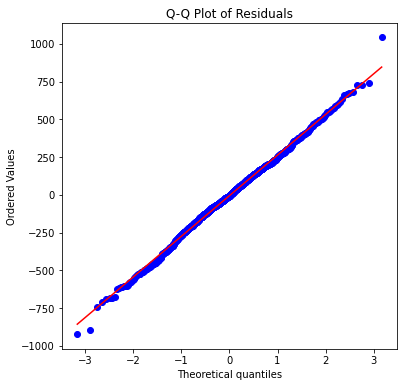

In [19]:
# 4. Q-Q Plot for normality check of the residuals
plt.figure(figsize=(6, 6))
stats.probplot(df['residual'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Observations:
- Observed heavy tails, indicating that there are outliers
- Non-normal distribution, (probably t distribution)

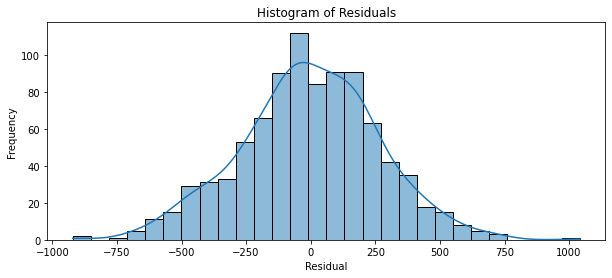

In [20]:
# 5. Histogram of the residuals
plt.figure(figsize=(10, 4))
sns.histplot(df['residual'], kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [22]:
# 6. Perform a normality test (Jarque-Bera Test)
def perform_jarque_bera_test(residuals):
    """Perform the Jarque-Bera test to check for normality in residuals."""
    jb_stat, p_value = stats.jarque_bera(residuals)
    skewness = residuals.skew()
    kurtosis = residuals.kurtosis()

    return {
        'JB Statistic': jb_stat,
        'p-value': p_value,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Normality': 'Reject H0 (Not Normal)' if p_value < 0.05 else 'Fail to Reject H0 (Normal)'
    }

jb_results = perform_jarque_bera_test(NASDAQ['log_returns'].dropna())
print(jb_results)

{'JB Statistic': 6909.791395448528, 'p-value': 0.0, 'Skewness': -0.6406655397082771, 'Kurtosis': 8.036989502139232, 'Normality': 'Reject H0 (Not Normal)'}


Observations:
-  A very small p-value means we reject the null hypothesis that states that residuals are normally distributed.

Thoughts from plots:
- Standard fBM assumes increments follow a normal distribution, but clearly this isn't the case here.

In [24]:
# 7. Perform a autocorrelation test for standardised residuals
import statsmodels.api as sm

def perform_box_ljung_test(residuals, lags=10):
    """Perform the Box-Ljung test to check for autocorrelation in standardized residuals."""
    residuals = (residuals - np.mean(residuals)) / np.std(residuals)

    lb_test = sm.stats.acorr_ljungbox(residuals, lags=[lags], return_df=True)
    return lb_test

box_ljung_results = perform_box_ljung_test(NASDAQ['log_returns'].dropna(), lags=10)
print(box_ljung_results)

      lb_stat     lb_pvalue
10  158.23607  7.491979e-29


### High Volatility Period

In [25]:
nasdaq_obj = utils.SnpDf(NASDAQ)
high_vol_df = utils.apply_rolling_predictions_from_start(nasdaq_obj, '2020-01-01', 150)
high_vol_df = high_vol_df[(high_vol_df.index >= '2020-01-01') & (high_vol_df.index <= '2022-01-01')]
high_vol_df = high_vol_df.join(NASDAQ, how='inner')
utils.compute_rmse(high_vol_df, 'predicted', 'price')

281.3179433465831

### Low Volatility Period

In [27]:
nasdaq_obj = utils.SnpDf(NASDAQ)
low_vol_df = utils.apply_rolling_predictions_from_start(nasdaq_obj, '2018-01-01', 150)
low_vol_df = low_vol_df[(low_vol_df.index >= '2018-01-01') & (low_vol_df.index <= '2020-01-01')]
low_vol_df = low_vol_df.join(NASDAQ, how='inner')
utils.compute_rmse(low_vol_df, 'predicted', 'price')

122.34473178039966

### Value-at-Risk Forecast

In [28]:
def compute_var_violations(df, var_col, return_col, confidence_level=0.95):
    df = df.dropna().copy()
    
    # Identify VaR exceedances (violations)
    df['exceedance'] = df[return_col] < df[var_col]  # True if actual return is less than VaR

    # Count actual exceedances
    actual_exceedances = df['exceedance'].sum()

    # Expected exceedances based on confidence level
    expected_exceedances = len(df) * (1 - confidence_level)

    # Violation ratio
    violation_ratio = actual_exceedances / expected_exceedances if expected_exceedances > 0 else np.nan

    return {
        'actual_exceedances': actual_exceedances,
        'expected_exceedances': expected_exceedances,
        'violation_ratio': violation_ratio
    }

# Compute 95% parametric VaR
NASDAQ['VaR_95'] = NASDAQ['log_returns'].rolling(250).quantile(0.05)  # 5th percentile

# Compute violation ratio
var_stats = compute_var_violations(NASDAQ, var_col='VaR_95', return_col='log_returns')
print(var_stats)

{'actual_exceedances': 125, 'expected_exceedances': 113.3000000000001, 'violation_ratio': 1.1032656663724616}


In [29]:
# Visualisation
def plot_var_violations(df, var_col, return_col, title="VaR Violations"):
    df = df.dropna().copy()

    # Identify VaR violations
    df['exceedance'] = df[return_col] < df[var_col]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[return_col], mode='lines', 
                             name="Actual Returns", line=dict(color='blue'), opacity=0.6))
    fig.add_trace(go.Scatter(x=df.index, y=df[var_col], mode='lines', 
                             name="VaR Threshold", line=dict(color='orange', dash='dot')))
    fig.add_trace(go.Scatter(x=df.index[df['exceedance']], 
                             y=df[return_col][df['exceedance']], 
                             mode='markers', name="VaR Violations", 
                             marker=dict(color='red', size=6, symbol='circle')))
    fig.update_layout(title=title,
                      xaxis_title="Date",
                      yaxis_title="Log Returns",
                      legend=dict(x=0, y=1),
                      hovermode="x unified",
                      template="plotly_white")
    fig.show()

plot_var_violations(NASDAQ, var_col='VaR_95', return_col='log_returns')